In [1]:
%load_ext autoreload
%autoreload 2
from get import *
from sklearn.manifold import TSNE
from matplotlib import cm

{0: '00_toy_dataset', 1: '01_mnist_cc', 2: '02_mnist_constant_image', 3: '03_mnist_constant_image_random_row', 4: '04_mnist_uniform_color_random_row', 5: '05_mnist_uniform_color_low_mix_rate', 6: '06_mnist_sum', 8: '08_mnist_sum_noise_level', 12: '12_mnist_mysterious', 13: '13_mnist_mysterious', 23: '23_mnist_embed', 456: '456_mnist_embed', 888: '888_vehicle_animal', 999: '999_humans'}


In [2]:
# Load data
X_labeled, y_labeled, X_unlabeled, X_val = load_datasets(n_dataset=456)
X_all = torch.concat((X_labeled, X_unlabeled, X_val))
labels_all = np.concatenate((y_labeled, np.zeros(X_unlabeled.shape[0]), np.ones(X_val.shape[0])))


In [3]:
print(X_labeled.shape)
print(X_unlabeled.shape)
print(X_val.shape)
print(X_all.shape)

print(y_labeled.unique())


torch.Size([1718, 198])
torch.Size([5153, 198])
torch.Size([1718, 198])
torch.Size([8589, 198])
tensor([4., 5., 6.])


In [4]:
# Project data and get projector
def get_2d_repr(embeddings):
    tsne = TSNE(2, verbose=1)
    tsne_proj = tsne.fit_transform(embeddings)
    return tsne, tsne_proj

tsne, repr_2d = get_2d_repr(X_all)

/home/t-boulet/projects/hackathon42/Hackaton42/timothe/venvHACK42/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/t-boulet/projects/hackathon42/Hackaton42/timothe/venvHACK42/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8589 samples in 0.002s...
[t-SNE] Computed neighbors for 8589 samples in 2.651s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8589
[t-SNE] Computed conditional probabilities for sample 2000 / 8589
[t-SNE] Computed conditional probabilities for sample 3000 / 8589
[t-SNE] Computed conditional probabilities for sample 4000 / 8589
[t-SNE] Computed conditional probabilities for sample 5000 / 8589
[t-SNE] Computed conditional probabilities for sample 6000 / 8589
[t-SNE] Computed conditional probabilities for sample 7000 / 8589
[t-SNE] Computed conditional probabilities for sample 8000 / 8589
[t-SNE] Computed conditional probabilities for sample 8589 / 8589
[t-SNE] Mean sigma: 25.701583
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.990463
[t-SNE] KL divergence after 1000 iterations: 2.098037


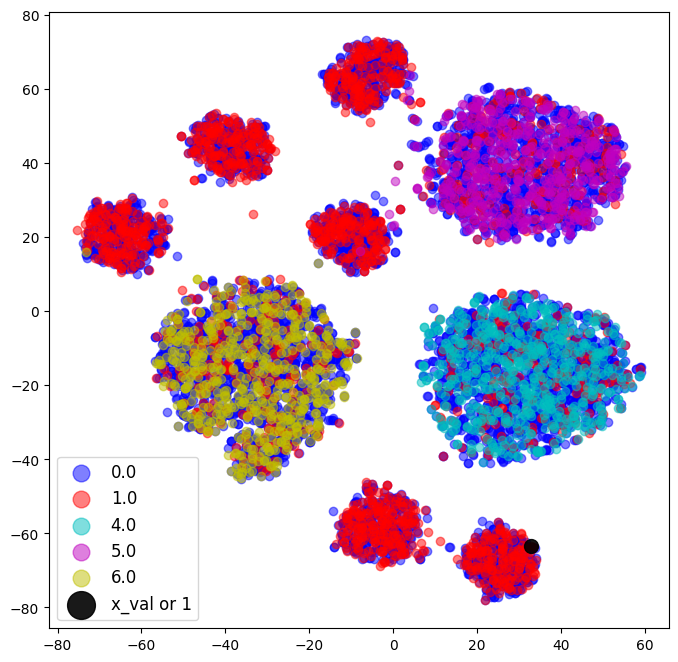

In [25]:
# Create a two dimensional t-SNE projection of the embeddings.
# Plot the points. We obserbe 4 clusters.
n_low = 131
k = 1
colors = ['b', 'r', 'g', 'y', 'c', 'm', 'y']
def plot_embedding_2d(embeddings, repr_2d, labels = None, title=None, plot_x_val_2d_repr = True):
    if labels is None:
        labels = np.zeros(embeddings.shape[0])
    # Plot those points as a scatter plot and label them based on the pred labels
    
    fig, ax = plt.subplots(figsize=(8,8))
    for lab in np.unique(labels):
        indices = labels==lab
        ax.scatter(repr_2d[indices,0], repr_2d[indices,1], c=colors[lab.astype(np.int32)], label = lab ,alpha=0.5)
    if plot_x_val_2d_repr:
        ax.scatter(repr_2d[labels == 1, 0][n_low: n_low + k], repr_2d[labels == 1, 1][n_low: n_low + k], c='k', label = 'x_val or 1', alpha=0.9, s = 100)
    ax.legend(fontsize='large', markerscale=2)
    plt.show()
    
plot_embedding_2d(X_all, repr_2d = repr_2d ,labels = labels_all)

In [6]:
from time import time

from pykeops.torch import LazyTensor
use_cuda = torch.cuda.is_available()
dtype = torch.float32 if use_cuda else torch.float64
device_id = "cuda:0" if use_cuda else "cpu"

embeddings_all = torch.concat((X_labeled, X_unlabeled, X_val))
K_clusters = 9
N, D, K = embeddings_all.shape[0], embeddings_all.shape[1], K_clusters

print(N, D, K)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
8589 198 9


In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=K_clusters, random_state=0, n_init=20).fit(embeddings_all)

In [9]:
# Cluster the points
cluster_classes_all = kmeans.labels_
c = kmeans.cluster_centers_
print("Centroids: " + str(kmeans.cluster_centers_.shape))
print("Labels: " + str(kmeans.labels_.shape))
print(cluster_classes_all[:10])

Centroids: (9, 198)
Labels: (8589,)
[2 2 2 2 2 3 0 0 0 3]


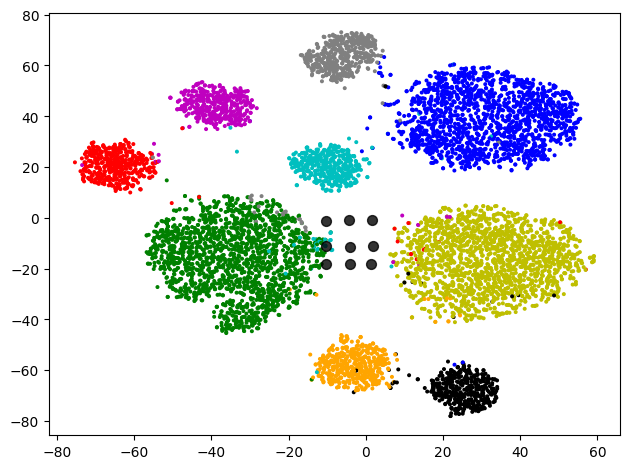

In [10]:
plt.figure()
colors = ['b', 'r', 'g', 'y', 'c', 'm', 'orange', 'k', 'grey']
colors2 = [colors[i] for i in cluster_classes_all]
plt.scatter(repr_2d[:, 0], repr_2d[:, 1], c=colors2, s=30000 / len(repr_2d))
plt.scatter(c[:, 0], c[:, 1], c="black", s=50, alpha=0.8)
plt.tight_layout()
plt.show()

In [27]:

# BLUE = cluster 0 = label 4
# GREEN = cluster 2 = label 6
# CYAN = cluster 4 = label 5

# RED = cluster 1 = label 4
# YELLOW = cluster 3 = label 6
# MAGENTA = cluster 5 = label probably 5
# ORANGE = cluster 6 = label 4
# BLACK = cluster 7 = label 6
# GREY = cluster 8 = label 5

cluster_classes_all # [cluster class of i for i in range(N)]



classes_all = np.copy(cluster_classes_all)

classes_all[cluster_classes_all == 3] = 4
classes_all[cluster_classes_all == 0] = 5
classes_all[cluster_classes_all == 2] = 6

classes_all[cluster_classes_all == 1] = 6
classes_all[cluster_classes_all == 4] = 5
classes_all[cluster_classes_all == 5] = 5
classes_all[cluster_classes_all == 6] = 4
classes_all[cluster_classes_all == 7] = 4
classes_all[cluster_classes_all == 8] = 6

classes_val = classes_all[labels_all == 1]

print(classes_val.shape)

(1718,)


In [28]:
df = pd.DataFrame(classes_val)
df.to_csv(f"submission_456_final.csv", header=False, index=False)